# Plots with confidence interval

In [17]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval


parameters = json.load(open("parameters.json"))

n_states_x = 17
n_states_v = 17
max_bellman_iterations = 6
max_bellman_iterations_validation = max_bellman_iterations + 10
seeds = range(1, 11)
n_seeds = len(seeds)
samples_threshold = 5
ticks_freq = 3 if max_bellman_iterations == 6 else 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General case

### Extract data

In [18]:
fqi_q = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v, 2))
fqi_v = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v))

for idx_seed, seed in enumerate(seeds):
    fqi_q[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy")
    fqi_v[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy")

optimal_q = np.load(f"figures/data/optimal/Q.npy")
optimal_v = np.load(f"figures/data/optimal/V.npy")

pbo_linear_q = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v, 2))
pbo_linear_v = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v))

for idx_seed, seed in enumerate(seeds):
    pbo_linear_q[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Q_{seed}.npy")
    pbo_linear_v[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_V_{seed}.npy")

PBO_linear_max_linear_q = np.zeros((n_seeds, max_bellman_iterations_validation + 1, n_states_x, n_states_v, 2))
PBO_linear_max_linear_v = np.zeros((n_seeds, max_bellman_iterations_validation + 1, n_states_x, n_states_v))

for idx_seed, seed in enumerate(seeds):
    PBO_linear_max_linear_q[idx_seed] = np.load(f"figures/data/PBO_linear_max_linear/{max_bellman_iterations}_Q_{seed}.npy")
    PBO_linear_max_linear_v[idx_seed] = np.load(f"figures/data/PBO_linear_max_linear/{max_bellman_iterations}_V_{seed}.npy")

samples_count = np.load(f"figures/data/samples_count.npy")
samples_mask = samples_count
samples_count_q_format = np.repeat(samples_count[:, :, None], 2, axis=-1)
samples_mask_q_format = samples_count_q_format

### Distances with the optimal Q function

In [19]:
fqi_q_mean = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
fqi_q_std = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
fqi_q_confidence_interval = confidence_interval(fqi_q_mean, fqi_q_std, n_seeds)

pbo_linear_q_mean = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
pbo_linear_q_std = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
pbo_linear_q_confidence_interval = confidence_interval(pbo_linear_q_mean, pbo_linear_q_std, n_seeds)

PBO_linear_max_linear_q_mean = np.sqrt(np.mean(np.square(PBO_linear_max_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
PBO_linear_max_linear_q_std = np.sqrt(np.mean(np.square(PBO_linear_max_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
PBO_linear_max_linear_q_confidence_interval = confidence_interval(PBO_linear_max_linear_q_mean, PBO_linear_max_linear_q_std, n_seeds)

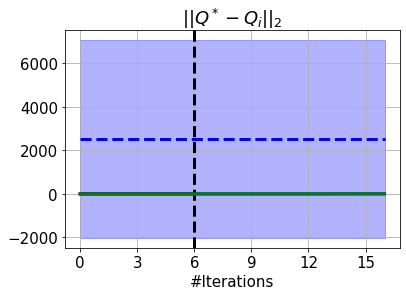

In [20]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_linear_q_mean[:-1], label="PBO linear", color="blue", zorder=7)
plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, :-1], pbo_linear_q_confidence_interval[1, :-1], color="blue", alpha=0.3)

plt.hlines(pbo_linear_q_mean[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="PBO linear fixed point", zorder=3)
plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, -1], pbo_linear_q_confidence_interval[1, -1], color="blue", alpha=0.3)

plt.plot(iterations_validation, PBO_linear_max_linear_q_mean, label="PBO deep", color="green", zorder=8)
plt.fill_between(iterations_validation, PBO_linear_max_linear_q_confidence_interval[0], PBO_linear_max_linear_q_confidence_interval[1], color="green", alpha=0.3)

plt.plot(iterations, fqi_q_mean, label="FQI", color="red", zorder=6)
plt.fill_between(iterations, fqi_q_confidence_interval[0], fqi_q_confidence_interval[1], color="red", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| Q^* - Q_i ||_2$")
# plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/distance_to_optimal_Q_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Visualization of the policies at iteration max_bellman_iterations

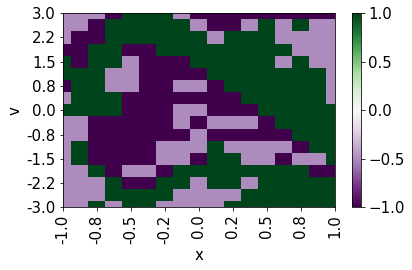

In [21]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_pi_weighted_average = (2 * ((optimal_q[:, :, 1] > optimal_q[:, :, 0])).astype(float) - 1) + (optimal_q[:, :, 1] == optimal_q[:, :, 0]).astype(float) / 2
# optimal_pi_weighted_average *= samples_mask

q_visu_mesh.set_values(optimal_pi_weighted_average)
q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
_ = plt.savefig(f"figures/optimal_pi.pdf", bbox_inches='tight')

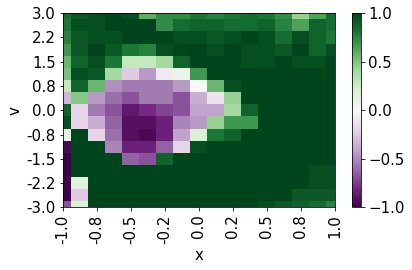

In [22]:
fqi_left_q = fqi_q[:, -1, :, :, 0]
fqi_right_q = fqi_q[:, -1, :, :, 1]
fqi_pi_weighted_average = (2 * (fqi_right_q > fqi_left_q).mean(axis=0) - 1)
# fqi_pi_weighted_average *= samples_mask

q_visu_mesh.set_values(fqi_pi_weighted_average)
q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
_ = plt.savefig(f"figures/fqi_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

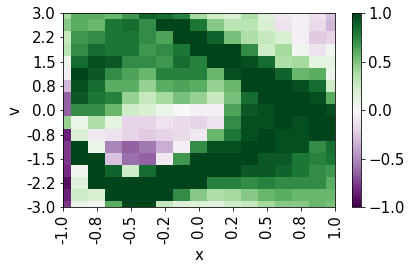

In [23]:
pbo_linear_left_q = pbo_linear_q[:, max_bellman_iterations, :, :, 0]
pbo_linear_right_q = pbo_linear_q[:, max_bellman_iterations, :, :, 1]
pbo_linear_pi_weighted_average = (2 * (pbo_linear_right_q > pbo_linear_left_q).mean(axis=0) - 1)
# pbo_linear_pi_weighted_average *= samples_mask

q_visu_mesh.set_values(pbo_linear_pi_weighted_average)
q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
_ = plt.savefig(f"figures/PBO_linear_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

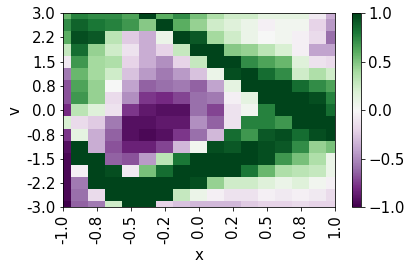

In [24]:
PBO_linear_max_linear_left_q = PBO_linear_max_linear_q[:, max_bellman_iterations, :, :, 0]
PBO_linear_max_linear_right_q = PBO_linear_max_linear_q[:, max_bellman_iterations, :, :, 1]
PBO_linear_max_linear_pi_weighted_average = (2 * (PBO_linear_max_linear_right_q > PBO_linear_max_linear_left_q).mean(axis=0) - 1)
# PBO_linear_max_linear_pi_weighted_average *= samples_mask

q_visu_mesh.set_values(PBO_linear_max_linear_pi_weighted_average)
q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
_ = plt.savefig(f"figures/PBO_linear_max_linear_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to optimal value function

In [25]:
fqi_v_mean = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
fqi_v_std = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
fqi_v_confidence_interval = confidence_interval(fqi_v_mean, fqi_v_std, n_seeds)

pbo_linear_v_mean = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
pbo_linear_v_std = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
pbo_linear_v_confidence_interval = confidence_interval(pbo_linear_v_mean, pbo_linear_v_std, n_seeds)

PBO_linear_max_linear_v_mean = np.sqrt(np.mean(np.square(PBO_linear_max_linear_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
PBO_linear_max_linear_v_std = np.sqrt(np.mean(np.square(PBO_linear_max_linear_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
PBO_linear_max_linear_v_confidence_interval = confidence_interval(PBO_linear_max_linear_v_mean, PBO_linear_max_linear_v_std, n_seeds)

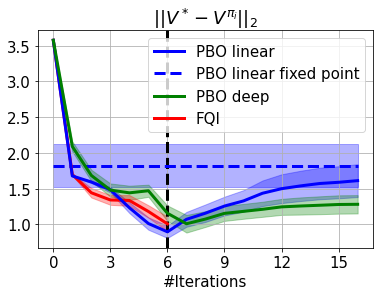

In [26]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_linear_v_mean[:-1], label="PBO linear", color="blue", zorder=7)
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, :-1], pbo_linear_v_confidence_interval[1, :-1], color="blue", alpha=0.3)

plt.hlines(pbo_linear_v_mean[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="PBO linear fixed point", zorder=3)
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, -1], pbo_linear_v_confidence_interval[1, -1], color="blue", alpha=0.3)

plt.plot(iterations_validation, PBO_linear_max_linear_v_mean, label="PBO deep", color="green", zorder=8)
plt.fill_between(iterations_validation, PBO_linear_max_linear_v_confidence_interval[0], PBO_linear_max_linear_v_confidence_interval[1], color="green", alpha=0.3)

plt.plot(iterations, fqi_v_mean, label="FQI", color="red", zorder=6)
plt.fill_between(iterations, fqi_v_confidence_interval[0], fqi_v_confidence_interval[1], color="red", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| V^* - V^{\pi_i} ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/distance_to_optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Value functions

In [27]:
fqi_v_mean_performance = (fqi_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
fqi_v_std_performance = (fqi_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
fqi_v_confidence_interval_performance = confidence_interval(fqi_v_mean_performance, fqi_v_std_performance, n_seeds)

pbo_linear_v_mean_performance = (pbo_linear_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
pbo_linear_v_std_performance = (pbo_linear_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
pbo_linear_v_confidence_interval_performance = confidence_interval(pbo_linear_v_mean_performance, pbo_linear_v_std_performance, n_seeds)

PBO_linear_max_linear_v_mean_performance = (PBO_linear_max_linear_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
PBO_linear_max_linear_v_std_performance = (PBO_linear_max_linear_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
PBO_linear_max_linear_v_confidence_interval_performance = confidence_interval(PBO_linear_max_linear_v_mean_performance, PBO_linear_max_linear_v_std_performance, n_seeds)

optimal_v_performance = (optimal_v * samples_mask).mean()

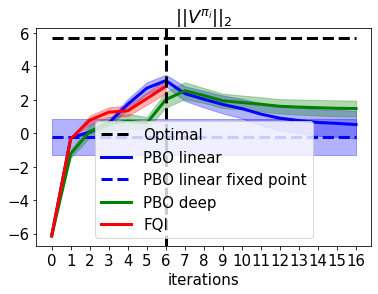

In [28]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.hlines(optimal_v_performance, 0, max_bellman_iterations_validation, color="black", linestyle="--", label="Optimal")

plt.plot(iterations_validation, pbo_linear_v_mean_performance[:-1], label="PBO linear", color="blue")
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_performance[0, :-1], pbo_linear_v_confidence_interval_performance[1, :-1], color="blue", alpha=0.3)

plt.hlines(pbo_linear_v_mean_performance[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="PBO linear fixed point")
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_performance[0, -1], pbo_linear_v_confidence_interval_performance[1, -1], color="blue", alpha=0.3)

plt.plot(iterations_validation, PBO_linear_max_linear_v_mean_performance, label="PBO deep", color="green")
plt.fill_between(iterations_validation, PBO_linear_max_linear_v_confidence_interval_performance[0], PBO_linear_max_linear_v_confidence_interval_performance[1], color="green", alpha=0.3)

plt.plot(iterations, fqi_v_mean_performance, label="FQI", color="red")
plt.fill_between(iterations, fqi_v_confidence_interval_performance[0], fqi_v_confidence_interval_performance[1], color="red", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.title(r"$|| V^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Visualization of the last value functions

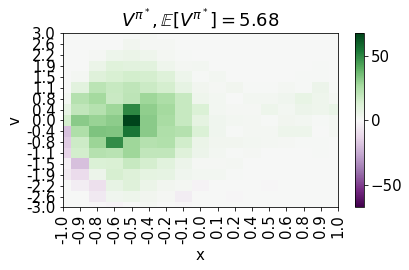

In [29]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_v_weighted_average = optimal_v * samples_mask

q_visu_mesh.set_values(optimal_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi^*}, \mathbb{E}\left[ V^{\pi^*} \right] =$" + str(np.round(np.mean(optimal_v_weighted_average), 2)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

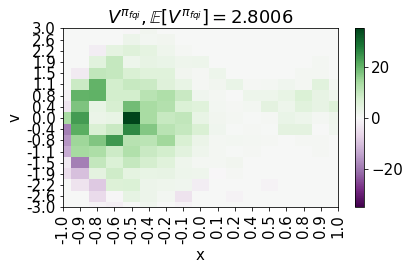

In [30]:
fqi_v_weighted_average = fqi_v[:, -1].mean(axis=0) * samples_mask

q_visu_mesh.set_values(fqi_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + f"{np.round(np.mean(fqi_v_weighted_average), 4)}", xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/fqi_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

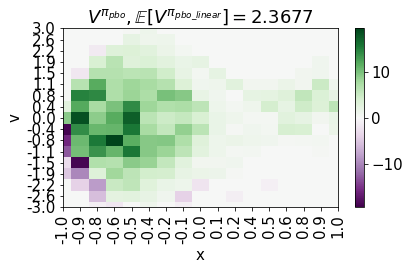

In [31]:
pbo_linear_v_weighted_average = pbo_linear_v[:, max_bellman_iterations + 1].mean(axis=0) * samples_mask

q_visu_mesh.set_values(pbo_linear_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo\_linear}} \right] =$" + str(np.round(np.mean(pbo_linear_v_weighted_average), 4)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/PBO_linear_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

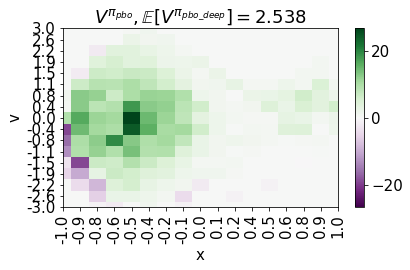

In [32]:
PBO_linear_max_linear_v_weighted_average = PBO_linear_max_linear_v[:, max_bellman_iterations + 1].mean(axis=0) * samples_mask

q_visu_mesh.set_values(PBO_linear_max_linear_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo\_deep}} \right] =$" + str(np.round(np.mean(PBO_linear_max_linear_v_weighted_average), 4)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/PBO_linear_max_linear_V_{max_bellman_iterations}.pdf", bbox_inches='tight')